# Scaling the Seasons
Each win or loss needs to be weighted based on the other games in the same season. We will put all the games together and apply zscore to the games.

Creates `scaled_games.csv` and `games_processed.csv`.

In [1]:
import math

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

full_games = pd.read_csv("games.csv")
full_teams = pd.read_csv("teams.csv",usecols=['abbrev','id','year'])

In [2]:
avgs = full_games[["Week", "Score", "year"]].groupby(["year", "Week"]).mean()
avgs.head(5)

Score
year Week          
2012 1     109.3125
     2     102.6250
     3     105.4375
     4     108.6875
     5     105.1875

In [3]:
team_avgs = full_games.merge(avgs, left_on=["Week", "year"], right_on=["Week", "year"]).merge(full_teams, left_on=["Team", "year"], right_on=["id", "year"])
team_avgs.rename(columns={"year_x": "year", "Score_x": "Score", "Score_y": "week_mean"}, inplace=True)
team_avgs["win"] = team_avgs["Margin"] > 0
team_avgs["for_diff"] = team_avgs["Score"] - team_avgs["week_mean"]
team_avgs["against_diff"] = team_avgs["OppScore"] - team_avgs["week_mean"]

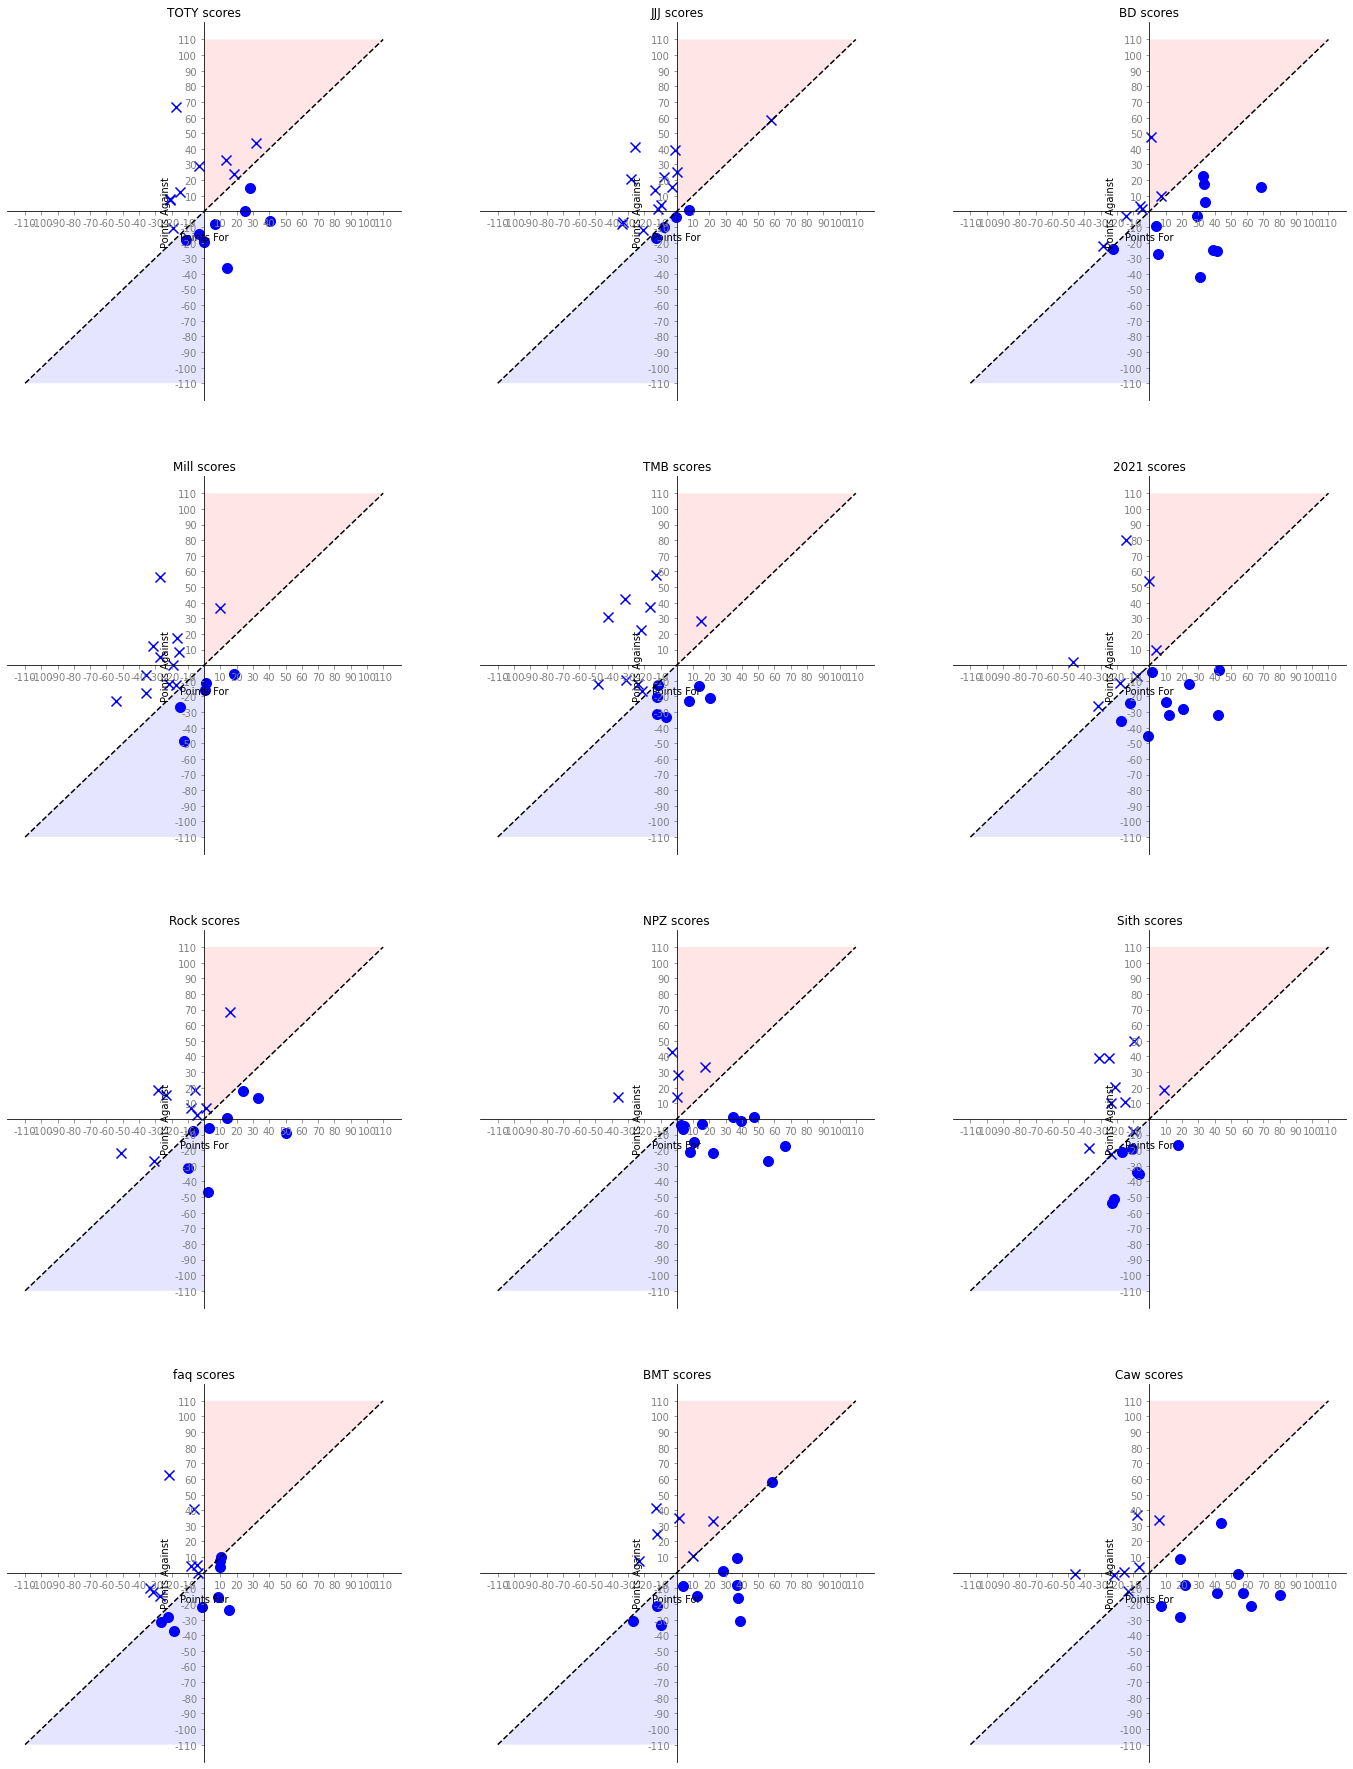

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(24,32))

z = 110

def build_plot(ax, data):
    ax.fill_between([-z,0], -z, [-z,0], facecolor='b', alpha=0.1)
    ax.fill_between([0,z], [0,z], z, facecolor='r', alpha=0.1)

    ax.scatter(data=data.query('win'), x='for_diff', y='against_diff', 
            c='b', 
            s=100,
            marker='o',
            label='Win')
    ax.scatter(data=data.query('not win'), x='for_diff', y='against_diff', 
            c='b', 
            s=100,
            marker='x',
            label='Loss')
    ax.plot([-z,z],[-z,z], 'k--')

    ax.set_xlabel('Points For')
    ax.set_ylabel('Points Against')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    tx = list(range(-z,z+1,10))
    tx.remove(0)
    ax.yaxis.set(ticks=tx, ticklabels=tx)
    ax.xaxis.set(ticks=tx, ticklabels=tx)

    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')
    
    ax.set(title='{} scores'.format(data["abbrev"].iloc[0]))

cur_teams = team_avgs.loc[team_avgs["year"] == 2021]
for idx, x in enumerate(cur_teams["id"].unique()):
    row = math.trunc(idx/3)
    col = idx - (row * 3)
    build_plot(ax[row][col], cur_teams.loc[cur_teams["Team"] == x])


In [5]:
team_avgs["unlucky_loss"] = 0
team_avgs["lucky_win"] = 0
team_avgs.loc[(team_avgs["win"] == False) & (team_avgs["for_diff"] > 0), "unlucky_loss"] = 1
team_avgs.loc[(team_avgs["win"] == True) & (team_avgs["for_diff"] < 0), "lucky_win"] = 1

In [6]:
team_avgs.to_csv("games_processed.csv")

In [7]:
scaler = StandardScaler()
def zscore(group):
    scaled = scaler.fit_transform(X=group[['lucky_win', 'unlucky_loss']])
    group["scaled_lucky_win"], group["scaled_unlucky_loss"] = scaled[:,0], scaled[:,1]
    return group

agg_team = team_avgs.groupby(["year", "Team"]).agg( {'lucky_win':sum, 'unlucky_loss': sum })
agg_team = agg_team.groupby(["year"]).apply(zscore)
agg_team.head(12)

lucky_win  unlucky_loss  scaled_lucky_win  scaled_unlucky_loss
year Team                                                                
2012 1             2             2          0.145865             0.229416
     2             5             1          2.479705            -0.688247
     3             4             1          1.701758            -0.688247
     4             2             4          0.145865             2.064742
     5             3             1          0.923812            -0.688247
     6             3             1          0.923812            -0.688247
     7             1             2         -0.632082             0.229416
     8             1             1         -0.632082            -0.688247
     9             2             3          0.145865             1.147079
     10            0             2         -1.410028             0.229416
     11            1             2         -0.632082             0.229416
     12            1             0         -0.632082            -1.605910

In [8]:
agg_team.to_csv("scaled_games.csv")